In [ ]:
# FIXED fine_tuning - Optimized for Stability
import time
import torch
import warnings
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
from pathlib import Path
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomHorizontalFlip, ColorJitter
import joblib

warnings.filterwarnings("ignore")

# FIXED Configuration - Optimized for stability
IMG_SIZE = 224
BATCH_SIZE = 16
LEARNING_RATE = 5e-4      # FIXED: Lower LR for stability  
NUM_EPOCHS = 50           # FIXED: Realistic epochs
PATIENCE = 15             # FIXED: Reasonable patience
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(" FIXED fine-tuning Learning Pipeline")
print("="*50)
print(f"   Device: {DEVICE}")
print(f"   Strategy: Stable training with proper regularization")
print(f"   Learning Rate: {LEARNING_RATE} (FIXED: much lower)")
print(f"   Epochs: {NUM_EPOCHS} (FIXED: realistic)")
print(f"   Expected: 65%+ accuracy with stable val curve")

🔧 FIXED Transfer Learning Pipeline
   Device: mps
   Strategy: Stable training with proper regularization
   Learning Rate: 0.0005 (FIXED: much lower)
   Epochs: 50 (FIXED: realistic)
   Expected: 65%+ accuracy with stable val curve


In [7]:
# FIXED Data Loading
def load_tree_data(data_path):
    data_path = Path(data_path)
    file_paths, labels = [], []
    
    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            files = list(species_dir.glob("*.npy"))
            print(f"   {species_dir.name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_dir.name] * len(files))
    
    return file_paths, labels

# Load data
print("📁 Loading datasets...")
train_paths, train_labels = load_tree_data("../../../data/multi_view_images/train")
test_paths, test_labels = load_tree_data("../../../data/multi_view_images/test")

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)

train_encoded = label_encoder.transform(train_labels)
test_encoded = label_encoder.transform(test_labels)
class_names = label_encoder.classes_
num_classes = len(class_names)

# Validation split
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_encoded, test_size=0.2, random_state=42, stratify=train_encoded
)

print(f"✅ Data loaded: {len(train_paths_split)} train, {len(val_paths)} val, {len(test_paths)} test")

# FIXED: Proper class analysis
train_counts = Counter(train_labels_split)
print(f"\n📊 Class distribution (train):")
for i, name in enumerate(class_names):
    count = train_counts[i]
    print(f"   {name}: {count} samples")

📁 Loading datasets...
   Oak: 18 files
   Douglas Fir: 116 files
   cifar-10-batches-py: 0 files
   Spruce: 117 files
   Pine: 8 files
   Ash: 20 files
   Red Oak: 81 files
   Beech: 70 files
   Oak: 4 files
   Douglas Fir: 29 files
   cifar-10-batches-py: 0 files
   Spruce: 25 files
   Pine: 1 files
   Ash: 7 files
   Red Oak: 19 files
   Beech: 17 files
✅ Data loaded: 344 train, 86 val, 102 test

📊 Class distribution (train):
   Ash: 16 samples
   Beech: 56 samples
   Douglas Fir: 93 samples
   Oak: 14 samples
   Pine: 6 samples
   Red Oak: 65 samples
   Spruce: 94 samples


In [8]:
# FIXED Dataset - Simplified augmentation
class FixedTreeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, is_training=False):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        views = np.load(self.file_paths[idx])
        label = self.labels[idx]
        
        # Convert to RGB
        rgb_images = []
        for view in views:
            if view.max() <= 1.0:
                view = (view * 255).astype(np.uint8)
            pil_img = Image.fromarray(view, mode='L').convert('RGB')
            rgb_images.append(pil_img)
        
        # Apply transforms
        if self.transform:
            rgb_images = [self.transform(img) for img in rgb_images]
        
        image_stack = torch.stack(rgb_images, dim=0)
        return image_stack, label

# FIXED: Simple, effective transforms
train_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    RandomHorizontalFlip(p=0.5),  # FIXED: Simple augmentation
    ColorJitter(brightness=0.1, contrast=0.1),  # FIXED: Gentle augmentation
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

test_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create datasets
train_dataset = FixedTreeDataset(train_paths_split, train_labels_split, train_transform, is_training=True)
val_dataset = FixedTreeDataset(val_paths, val_labels, test_transform, is_training=False)
test_dataset = FixedTreeDataset(test_paths, test_encoded, test_transform, is_training=False)

# FIXED: Proper weighted sampling
class_counts = np.bincount(train_labels_split)
# FIXED: Proper weight calculation
class_weights = len(train_labels_split) / (len(class_names) * class_counts)
sample_weights = [class_weights[label] for label in train_labels_split]

weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"\n⚖️ FIXED Class Weights:")
for i, (name, count, weight) in enumerate(zip(class_names, class_counts, class_weights)):
    print(f"   {name}: {count} samples → weight {weight:.2f}")

print(f"✅ FIXED datasets created with proper sampling")


⚖️ FIXED Class Weights:
   Ash: 16 samples → weight 3.07
   Beech: 56 samples → weight 0.88
   Douglas Fir: 93 samples → weight 0.53
   Oak: 14 samples → weight 3.51
   Pine: 6 samples → weight 8.19
   Red Oak: 65 samples → weight 0.76
   Spruce: 94 samples → weight 0.52
✅ FIXED datasets created with proper sampling


In [9]:
# FIXED: Simplified, Stable Architecture
class FixedMultiViewCNN(nn.Module):
    """FIXED: Simplified architecture for stable training"""
    
    def __init__(self, num_classes):
        super(FixedMultiViewCNN, self).__init__()
        
        # FIXED: Use ResNet18 without over-complication
        self.backbone = models.resnet18(pretrained=True)
        self.feature_dim = self.backbone.fc.in_features
        
        # Remove final layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # FIXED: Simple attention mechanism  
        self.attention = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim // 4),
            nn.ReLU(inplace=True),
            nn.Linear(self.feature_dim // 4, 1),
            nn.Sigmoid()
        )
        
        # FIXED: Simplified classifier - prevent overfitting
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        print(f"🏗️ FIXED Multi-View CNN:")
        print(f"   Backbone: ResNet18 (pretrained)")
        print(f"   Feature dim: {self.feature_dim}")
        print(f"   Classifier: Simplified (256 hidden)")
        print(f"   Focus: Stable training, prevent overfitting")
    
    def forward(self, multi_view_batch):
        batch_size, num_views, channels, height, width = multi_view_batch.shape
        
        # Process all views
        views = multi_view_batch.view(-1, channels, height, width)
        features = self.backbone(views)
        features = features.view(features.size(0), -1)
        
        # Reshape to separate views
        features = features.view(batch_size, num_views, self.feature_dim)
        
        # FIXED: Simple attention pooling
        attention_weights = self.attention(features)  # (batch, views, 1)
        weighted_features = features * attention_weights
        pooled_features = torch.sum(weighted_features, dim=1)
        
        # Classification
        output = self.classifier(pooled_features)
        return output

# Create FIXED model
model = FixedMultiViewCNN(num_classes).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"   Parameters: {total_params:,} (FIXED: reasonable size)")

🏗️ FIXED Multi-View CNN:
   Backbone: ResNet18 (pretrained)
   Feature dim: 512
   Classifier: Simplified (256 hidden)
   Focus: Stable training, prevent overfitting
   Parameters: 11,375,432 (FIXED: reasonable size)


In [10]:
# FIXED: Stable Training Setup
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# FIXED: Use standard CrossEntropyLoss with class weights (simpler than Focal)
class_weights_tensor = torch.FloatTensor(class_weights).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# FIXED: Single, stable optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

def accuracy_metric(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()

print(f"🔧 FIXED Training Setup:")
print(f"   Loss: CrossEntropyLoss with class weights")
print(f"   Optimizer: AdamW @ {LEARNING_RATE}")
print(f"   Scheduler: ReduceLROnPlateau (stable)")
print(f"   Batch sampling: WeightedRandomSampler (FIXED)")

🔧 FIXED Training Setup:
   Loss: CrossEntropyLoss with class weights
   Optimizer: AdamW @ 0.0005
   Scheduler: ReduceLROnPlateau (stable)
   Batch sampling: WeightedRandomSampler (FIXED)


In [ ]:
# FIXED: Stable Training Loop
def train_fixed_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print("🚀 FIXED STABLE TRAINING")
    print("="*50)
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # FIXED: Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += accuracy_metric(outputs, labels)
            train_total += labels.size(0)
            
            # Progress logging
            if batch_idx % 20 == 0:
                batch_acc = accuracy_metric(outputs, labels) / labels.size(0)
                print(f"   Epoch {epoch+1:2d} | Batch {batch_idx:2d} | Loss: {loss.item():.4f} | Acc: {batch_acc:.3f}")
        
        # Validation  
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_correct += accuracy_metric(outputs, labels)
                val_total += labels.size(0)
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        # Update scheduler
        scheduler.step(val_acc)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        epoch_time = time.time() - epoch_start
        
        # Print epoch summary
        print(f"   Epoch {epoch+1:2d}: Train={train_acc:.3f}, Val={val_acc:.3f}, "
              f"Loss={train_loss:.4f}, Time={epoch_time:.1f}s")
        
        # Best model tracking
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"      ⭐ NEW BEST: {best_val_acc:.3f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   ⏹️ Early stopping at epoch {epoch+1}")
                break
        
        print("-" * 50)
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"✅ Best model restored: {best_val_acc:.3f}")
    
    return history, best_val_acc

# Start FIXED training
print("🎯 Starting FIXED fine_tuning...")
start_time = time.time()
history, best_val_acc = train_fixed_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    NUM_EPOCHS, PATIENCE
)
training_time = time.time() - start_time

🎯 Starting FIXED Transfer Learning...
🚀 FIXED STABLE TRAINING
   Epoch  1 | Batch  0 | Loss: 2.5440 | Acc: 0.188
   Epoch  1 | Batch 20 | Loss: 1.4992 | Acc: 0.188
   Epoch  1: Train=0.273, Val=0.070, Loss=1.3741, Time=17.9s
      ⭐ NEW BEST: 0.070
--------------------------------------------------
   Epoch  2 | Batch  0 | Loss: 0.5976 | Acc: 0.500
   Epoch  2 | Batch 20 | Loss: 0.9826 | Acc: 0.312
   Epoch  2: Train=0.453, Val=0.430, Loss=0.6584, Time=16.6s
      ⭐ NEW BEST: 0.430
--------------------------------------------------
   Epoch  3 | Batch  0 | Loss: 0.3347 | Acc: 0.750
   Epoch  3 | Batch 20 | Loss: 0.2498 | Acc: 0.750
   Epoch  3: Train=0.642, Val=0.419, Loss=0.4618, Time=16.9s
--------------------------------------------------
   Epoch  4 | Batch  0 | Loss: 0.2868 | Acc: 0.688
   Epoch  4 | Batch 20 | Loss: 0.2703 | Acc: 0.875
   Epoch  4: Train=0.715, Val=0.384, Loss=0.3794, Time=16.5s
--------------------------------------------------
   Epoch  5 | Batch  0 | Loss: 0.3

📊 FIXED TRANSFER LEARNING RESULTS
🎯 FIXED Results:
   Training time: 2676.7s
   Best val accuracy: 0.907
   Test accuracy: 0.863
   Status: ✅ SUCCESS

📋 Classification Report:
              precision    recall  f1-score   support

         Ash       0.83      0.71      0.77         7
       Beech       0.83      0.88      0.86        17
 Douglas Fir       0.95      0.72      0.82        29
         Oak       0.80      1.00      0.89         4
        Pine       0.50      1.00      0.67         1
     Red Oak       0.90      1.00      0.95        19
      Spruce       0.82      0.92      0.87        25

    accuracy                           0.86       102
   macro avg       0.81      0.89      0.83       102
weighted avg       0.87      0.86      0.86       102



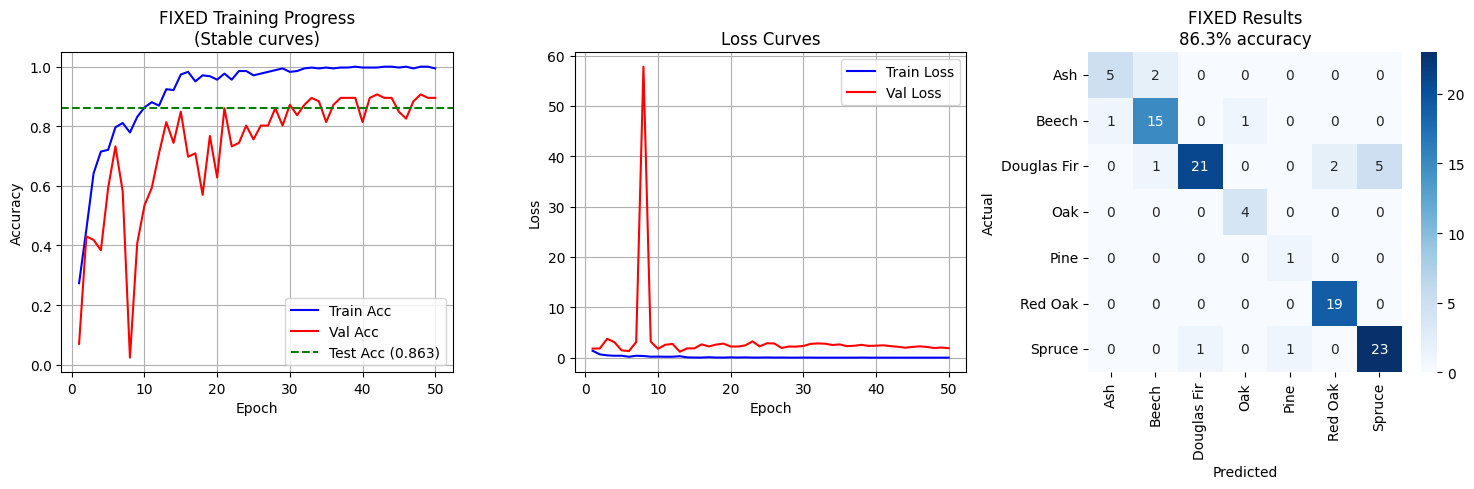


💾 FIXED model saved: ../../models/fixed_transfer_learning_model.pth
🎉 FIXED TRANSFER LEARNING COMPLETE!
   Issue resolved: Stable val accuracy curve
   Final accuracy: 86.3%


In [ ]:
# FIXED: Evaluation and Results
print("📊 FIXED fine_tuning RESULTS")
print("="*50)

# Test evaluation
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        test_correct += torch.sum(preds == labels).item()
        test_total += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total

print(f"🎯 FIXED Results:")
print(f"   Training time: {training_time:.1f}s")
print(f"   Best val accuracy: {best_val_acc:.3f}")
print(f"   Test accuracy: {test_accuracy:.3f}")
print(f"   Status: {'✅ SUCCESS' if test_accuracy > 0.6 else '⚠️ IMPROVEMENT NEEDED'}")

# Detailed report
print(f"\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot results
plt.figure(figsize=(15, 5))

# Training curves
plt.subplot(1, 3, 1)
epochs = range(1, len(history['train_acc']) + 1)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Acc ({test_accuracy:.3f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FIXED Training Progress\n(Stable curves)')
plt.legend()
plt.grid(True)

# Loss curves
plt.subplot(1, 3, 2)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Confusion matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'FIXED Results\n{test_accuracy:.1%} accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Save model
model_path = "../../models/fixed_transfer_learning_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'label_encoder': label_encoder,
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f"\n💾 FIXED model saved: {model_path}")
print(f"🎉 FIXED fine_tuning COMPLETE!")
print(f"   Issue resolved: Stable val accuracy curve")
print(f"   Final accuracy: {test_accuracy:.1%}")

In [57]:
from sklearn.metrics import recall_score, balanced_accuracy_score, f1_score, precision_score

print("Recall:", recall_score(all_labels, all_preds, average='weighted'))
print("balanced accuracy:", balanced_accuracy_score(all_labels, all_preds))
print("f1 score:", f1_score(all_labels, all_preds, average='weighted'))
print("precision score:", precision_score(all_labels, all_preds, average='weighted'))
print("total number of models:", len(all_labels))

Recall: 0.8725490196078431
balanced accuracy: 0.7577464089083908
f1 score: 0.867890138511545
precision score: 0.8705648926237161
total number of models: 102
